<a href="https://colab.research.google.com/github/nikwolfe7/micrograd/blob/master/micrograd_yay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import math
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [95]:
def f(x):
  return 3 * x ** 2 - 4 * x + 5

In [96]:
f(3.0)

20.0

In [97]:
# range of numbers from -5 to 5, steps of 0.25
xs = np.arange(-5, 5, 0.25)
# get a set of values for f(x)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

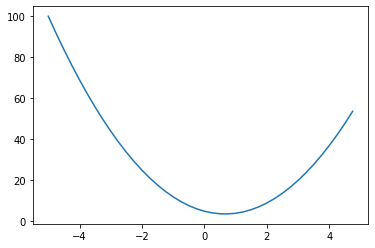

In [98]:
plt.plot(xs, ys)

From https://en.wikipedia.org/wiki/Derivative

In [99]:
# h = 0.00000000000000001 # note this value is too small, leads to underflow
h = 0.00000001
x = 3.0

# definition of the derivative
# (f(x + h) - f(x)) / h

Derivative of the function using power rule

In [100]:
# 3 * x ** 2 - 4 * x + 5
def dfdx(x):
  return 6 * x - 4

See it's the same value. Yay.

In [101]:
dfdx(x)

14.0

Getting more complex...

In [102]:
def fd(a, b, c):
  return a * b + c

In [103]:
a = 2.0
b = -3.0
c = 10.0
d = fd(a, b, c)
print(d)

4.0


Evaluating the derivative of the function above `a * b + c` with respect to each variable

In [104]:
h = 0.00001

# fix the inputs
a = 2.0
b = -3.0
c = 10.0

d1 = fd(a, b, c)
# increas a by h to get small change in function
c += h
d2 = fd(a, b, c)

print(f"d1 = {d1}, d2 = {d2}, slope = {(d2 - d1)/h}")

d1 = 4.0, d2 = 4.00001, slope = 0.9999999999621422


Making the code above more modular...

In [105]:
h = 0.00001

# fix the inputs
a = 2.0
b = -3.0
c = 10.0

# differentiability
# L = lim(h -> 0) (f(a + h) - f(a)) / h

# Derivative with respect to a
df_da = (fd(a+h, b, c) - fd(a, b, c)) / h

print(f"df/da:\n d1 = {fd(a,b,c)}, d2 = {fd(a+h,b,c)}, slope = {df_da}")

# Derivative with respect to b
df_db = (fd(a, b+h, c) - fd(a, b, c)) / h

print(f"df/db:\n d1 = {fd(a,b,c)}, d2 = {fd(a,b+h,c)}, slope = {df_db}")

# Derivative with respect to c
df_dc = (fd(a, b, c+h) - fd(a, b, c)) / h

print(f"df/db:\n d1 = {fd(a,b,c)}, d2 = {fd(a,b,c+h)}, slope = {df_dc}")

df/da:
 d1 = 4.0, d2 = 3.9999699999999994, slope = -3.000000000064062
df/db:
 d1 = 4.0, d2 = 4.00002, slope = 2.0000000000131024
df/db:
 d1 = 4.0, d2 = 4.00001, slope = 0.9999999999621422


Test function to compute derivative of arbitrary function w.r.t (with respect to) a variable in the args list

In [106]:
def gradient(func, args, wrt):
    h = 0.00001
    # find which arg we're deriving with respect to
    h_args = []
    for arg in list(args):
      if wrt is arg:
        arg += h
      h_args.append(arg)
    h_args = tuple(h_args)
    # (f(a+h) - f(a)) / h
    g = (func(*h_args) - func(*args)) / h
    return g

In [107]:
# fix the inputs
a = 2.0
b = -3.0
c = 10.0

# Derivative with respect to a
df_da = (fd(a+h, b, c) - fd(a, b, c)) / h
print(f"df_da: {df_da}")

# Derivative with respect to b
df_db = (fd(a, b+h, c) - fd(a, b, c)) / h
print(f"df_db: {df_db}")

# Derivative with respect to c
df_dc = (fd(a, b, c+h) - fd(a, b, c)) / h
print(f"df_dc: {df_dc}")

df_da: -3.000000000064062
df_db: 2.0000000000131024
df_dc: 0.9999999999621422


In [108]:
print(f"df_da: {gradient(fd, (a,b,c), wrt=a)}")
print(f"df_db: {gradient(fd, (a,b,c), wrt=b)}")
print(f"df_dc: {gradient(fd, (a,b,c), wrt=c)}")

df_da: -3.000000000064062
df_db: 2.0000000000131024
df_dc: 0.9999999999621422


# Implementing `Value` Class

In [109]:
import copy

class Value:

  # used for computing gradients
  h = 0.000000001
  # TODO(nikwolfe7): Remove autograd flag when we confirm it works
  do_autograd = True

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
  

  def __repr__(self):
    return f"Value(data={self.data})"

  
  def _autograd(self, func, args, wrt):
    # find which arg we're deriving with respect to
    h_args = []
    for arg in args:
      # must point to same reference
      if wrt is arg: 
        # arg must be a new value object
        arg = Value(arg.data)
        arg.data += self.h
      h_args.append(arg)
    h_args = tuple(h_args)
    # definition of derivative
    # (f(a+h) - f(a)) / h
    g = (func(*h_args) - func(*args)) * (self.h ** -1)
    return g


  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other, label=str(other))
    def _add(a, b):
      return a.data + b.data

    v = _add(self, other)
    out = Value(v, (self, other), '+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    
    out._backward = _backward
    return out


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other, label=str(other))
    def _mul(a, b):
      return a.data * b.data
    
    v = _mul(self, other)
    out = Value(v, (self, other), '*')

    def _backward():
      if self.do_autograd:
        self.grad += self._autograd(_mul, (self, other), wrt=self) * out.grad
        other.grad += self._autograd(_mul, (self, other), wrt=other) * out.grad
      else:
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad

    out._backward = _backward
    return out


  def tanh(self):
    def _tanh(a):
      return (math.exp(2 * a.data) - 1.0) / (math.exp(2 * a.data) + 1.0) 
    
    v = _tanh(self)
    out = Value(v, _children=(self, ), _op='tanh')

    def _backward():
      if self.do_autograd:
        self.grad += self._autograd(_tanh, (self,), wrt=self) * out.grad
      else:
        # d/dx tanh(x) = 1 - tanh(x)^2
        self.grad += (1.0 - v ** 2) * out.grad

    out._backward = _backward
    return out

  
  def sigmoid(self):
    def _sigmoid(a):
      # 1 / (1 + e^(-x))
      return (1 + math.exp(-a.data)) ** -1
    
    v = _sigmoid(self)
    out = Value(v, _children=(self,), _op='sigmoid')

    def _backward():
      if self.do_autograd:
        self.grad += self._autograd(_sigmoid, (self,), wrt=self) * out.grad
      else:
        # d/dx sig(x) = sig(x)(1 - sig(x))
        self.grad += out.data * (1 - out.data) * out.grad
    
    out._backward = _backward
    return out


  def softplus(self):
    def _softplus(a):
      # f(x) = log(1 + exp(x))
      return math.log(1 + math.exp(a.data))
    
    v = _softplus(self)
    out = Value(v, _children=(self,), _op='softplus')

    def _backward():
      if self.do_autograd:
        self.grad += self._autograd(_softplus, (self,), wrt=self) * out.grad
      else:
        # d/dx softplus(x) = sigmoid(x)
        self.grad += self.sigmoid().data * out.grad
    
    out._backward = _backward
    return out
  

  def relu(self):
    def _relu(a):
      return max(0, a.data)
    
    v = _relu(self)
    out = Value(v, _children=(self,), _op='ReLU')

    def _backward():
      if self.do_autograd:
        self.grad += self._autograd(_relu, (self,), wrt=self) * out.grad
      else:
        self.grad += (self.data > 0) * out.grad
    
    out._backward = _backward
    return out


  def __pow__(self, other): 
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    def _pow(a, b):
      return a.data ** b

    v = _pow(self, other)  
    out = Value(v, (self,), f"**{other}")

    def _backward():
      if self.do_autograd:
        self.grad += self._autograd(_pow, (self, other), self) * out.grad
      else:
        # power rule...
        self.grad += other * _pow(self, other - 1) * out.grad

    out._backward = _backward
    return out


  def exp(self):
    """returns e^(data)"""
    def _exp(a):
      return math.exp(a.data)
    
    v = _exp(self)
    out = Value(v, (self,), _op='exp')

    def _backward():
      if self.do_autograd:
        self.grad += self._autograd(_exp, (self,), wrt=self) * out.grad
      else:
        # d/dx e^x = e^x
        self.grad += out.data * out.grad
    
    out._backward = _backward
    return out
  

  def __neg__(self): # -self
    return self * -1


  def __sub__(self, other): # subtraction
    return self + (-other)  


  def __rmul__(self, other): # other is self
    return self * other

  
  def __radd__(self, other): # other is self
    return self + other


  def __truediv__(self, other): # self / other
    return self * other ** -1


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # run backprop in reverse topological order
    self.grad = 1.0
    for val in reversed(topo):
      val._backward()


In [110]:
def test():
  a = Value(2.0, label='a')
  b = Value(4.0, label='b')
  a.do_autograd = True
  b.do_autograd = True
  print(a / b)

  a.backward()
  print(a.grad)

test()

Value(data=0.5)
1.0


# GraphViz Functions to Display Computation Graph

In [111]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      # if this value is a result of some operation , create a node op for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Let's create some values! And do ops on them!

In [112]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd' 
L = d * f; L.label = 'L'

print(a + b)
print(a * b)
print(a * b + c)

# using the function fd() from above
# d = fd(a, b, c)

print(d._prev)
print(d._op)

Value(data=-1.0)
Value(data=-6.0)
Value(data=4.0)
{Value(data=-6.0), Value(data=10.0)}
+


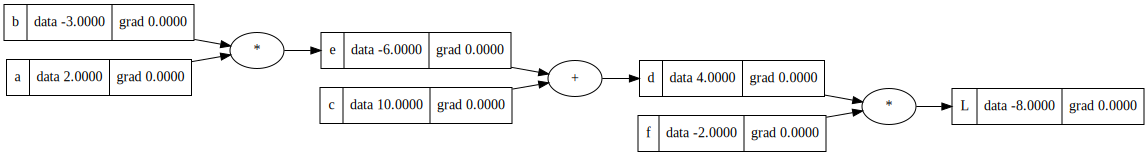

In [113]:
draw_dot(L)

Adding derivatives... 

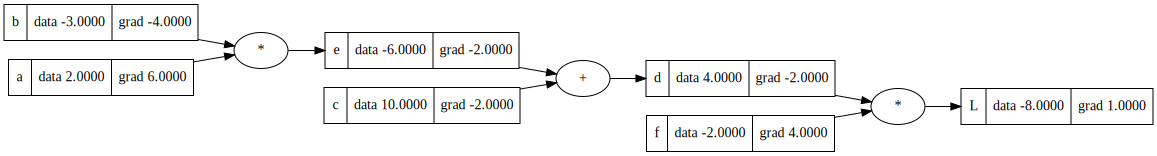

In [114]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data

# Applying the chain rule for c.grad and e.grad
# dL/dc = (dL/dd) * (dd/dc)
# dL/de = (dL/dd) * (dd/de)
# since d = c + e, dd/dc = 1.0
# since d = c + e, dd/de = 1.0
# dL/dd = d.grad
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0 

# Applying the chain rule for a.grad and b.grad
# dL/da = (dL/de) * (de/da)
# dL/db = (dL/de) * (de/db)
# since e = a * b, de/da = b
# since e = a * b, de/db = a
# dL/de = e.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data

draw_dot(L)

# Manual Graph Update

Applying gradient update rule...

The new value should be ... `current value += eta * gradient`

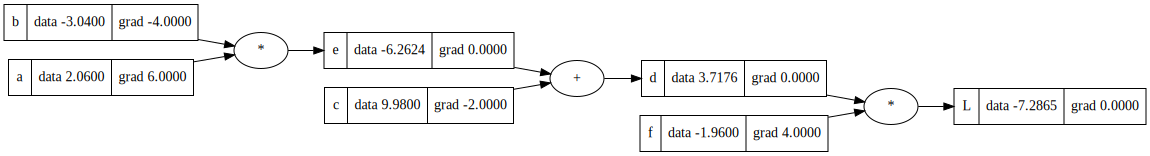

In [115]:
eta = 0.01

a.data += eta * a.grad
b.data += eta * b.grad
c.data += eta * c.grad
f.data += eta * f.grad

# forward pass... 
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L' 

draw_dot(L)

# LOL function for manually computing derivatives

Manually computing a derivative... 

Create all of our variables in a function to keep from polluting the global scope

In [116]:
def lol():
  # h
  h = 0.0000001

  # values
  a = Value(2.0,  label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  f = Value(-2.0, label='f')

  # ops
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  L = d * f; L.label = 'L' 
  L1 = L.data

  # add h 
  # a.data += h
  b.data += h
  # f.data += h
  # c.data += h
  

  # ops
  e = a * b; e.label = 'e'
  # e.data += h
  d = e + c; d.label = 'd'
  # d.data += h
  L = d * f; L.label = 'L' 
  L2 = L.data # + h # adding h to L to take that derivative

  print(f"dL/d? = {(L2 - L1) / h}")

lol()

dL/d? = -3.9999999934536845


A nice quote about the chain rule from https://en.wikipedia.org/wiki/Chain_rule

"if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

# Neuron Backprop

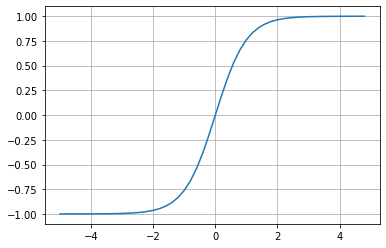

In [117]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Some values for our neuron...

In [118]:
def build_graph():
  # inputs
  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')

  # weights
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')

  # bias
  b = Value(6.8813735870195432, label='b')

  # weights x inputs
  x1w1 = x1 * w1; x1w1.label = 'x1*w1'
  x2w2 = x2 * w2; x2w2.label = 'x2*w2'

  # dot product
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

  # adding the bias
  n = x1w1x2w2 + b; n.label = 'n'

  o = n.tanh(); o.label = 'o'

  return o


In [119]:
o = build_graph()

Running the backward function on our values...

In [120]:
o.grad = 1.0 # since grad initialized as 0.0

## Example 1:
hard coding the gradients...

In [121]:
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = 1 - tanh(n)^2
# #       = 1 - o^2
# n.grad = 1 - o.data ** 2

# # do/dx1w1... = do/dn * dn/dx1w1...
# # n = x1w1x2w2 + b
# # dn/dx1w1... = 1.0
# x1w1x2w2.grad = 1.0 * n.grad
# b.grad = 1.0 * n.grad

# # do/dx1w1 = do/dx1w1x2w2 * dx1w1x2w2/dx1w1
# # do/dx1w1x2w2 = x1w1x2w2.grad
# # x1w1x2w2 = x1w1 + x2w2
# # dx1w1x2w2/dx1w1 = 1.0
# # dx1w1x2w2/dx2w2 = 1.0
# x1w1.grad = x1w1x2w2.grad * 1.0
# x2w2.grad = x1w1x2w2.grad * 1.0

# # do/dx2 = do/dx2w2 * dx2w2/dx2
# # do/dx2w2 = x2w2.grad
# # x2w2 = x2 * w2
# # dx2w2/dx2 = w2
# # dx2w2/dw2 = x2
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

# # do/dx1 = do/dx1w1 * dx1w1/dx1
# # do/dx1w1 = x1w1.grad
# # x1w1 = x1 * w1
# # dx1w1/dx1 = w1
# # dx1w1/dw1 = x1
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data

In [122]:
# draw_dot(o)

## Example 2:
Running backprop in topological order manually

In [123]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# weights x inputs
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# dot product
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# adding the bias
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.grad = 1.0

# Run the backprop in order on the graph
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()
w1._backward()
x1._backward()
w2._backward()
x2._backward()

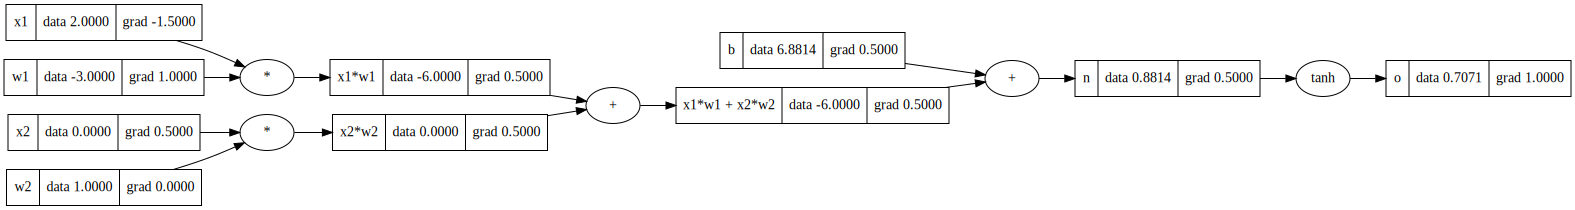

In [124]:
draw_dot(o)

In [125]:
# draw_dot(o)

# Topologically Sorting Graph for Backprop


In [126]:
# Function to topologically sort a graph of values
def topological_sort(val):
  topo = []
  visited = set()
  def build_topo(v):
    if v not in visited:
      visited.add(v)
      for child in v._prev:
        build_topo(child)
      topo.append(v)
  build_topo(val)
  return topo

In [127]:
o = build_graph() # reset the graph
o.grad = 1.0 # default gradient for output

In [128]:
topological_sort(o)

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

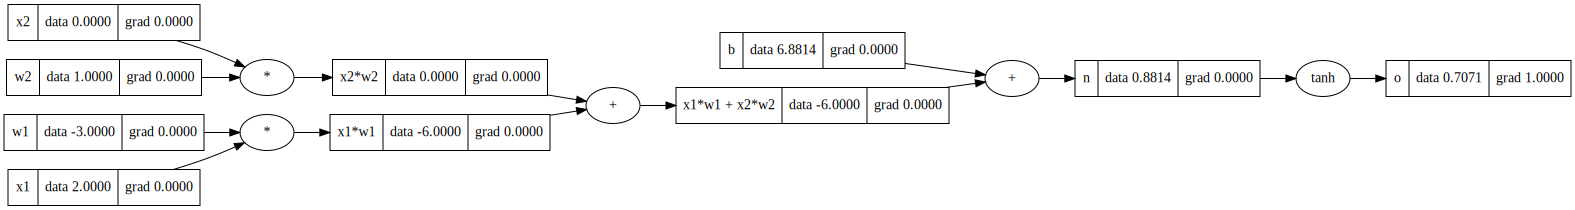

In [129]:
draw_dot(o)

Run backprop in reversed topological order

In [130]:
for val in reversed(topological_sort(o)):
  val._backward()

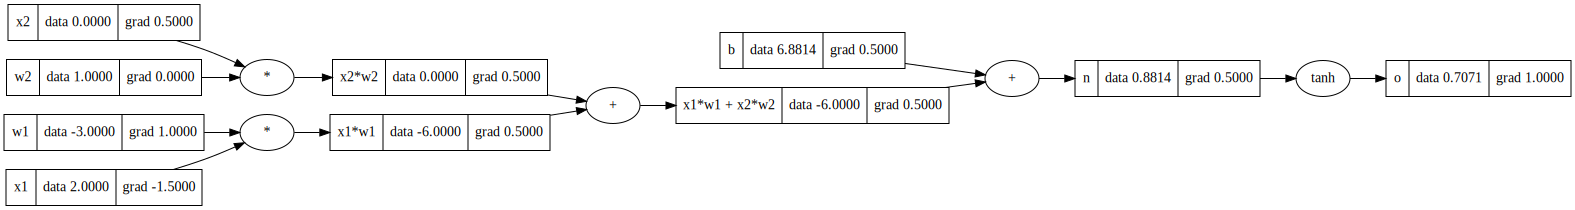

In [131]:
draw_dot(o)

# Using Backprop From The Value Class

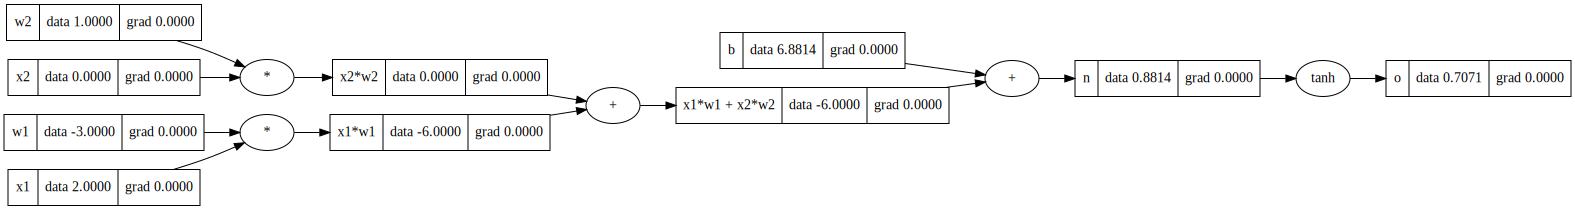

In [132]:
o = build_graph() # reset the graph
draw_dot(o)

Calling `backward` now is one line

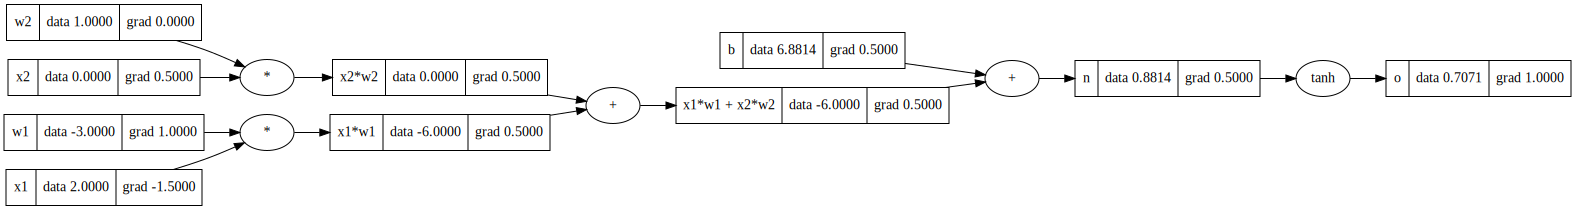

In [133]:
o.backward()
draw_dot(o)

Testing a bug stated in the video...

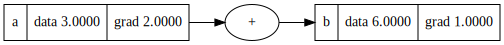

In [134]:
def test0():
  a = Value(3.0, label='a')
  b = a + a; b.label = 'b'
  b.backward()
  return b
draw_dot(test0())

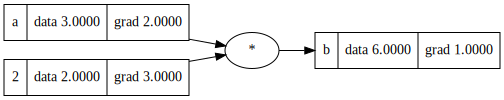

In [135]:
def test1():
  a = Value(3.0, label='a')
  b = a * 2; b.label = 'b'
  b.backward()
  return b
draw_dot(test1())

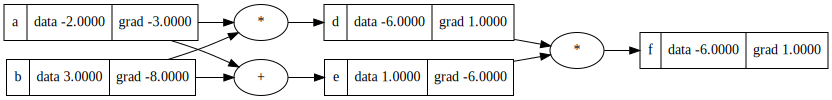

In [136]:
def test2():
  a = Value(-2.0, label='a')
  b = Value(3.0, label='b')
  d = a * b; d.label = 'd'
  e = a + b; e.label = 'e'
  f = d * e; f.label = 'f'

  f.backward()
  return f

draw_dot(test2())

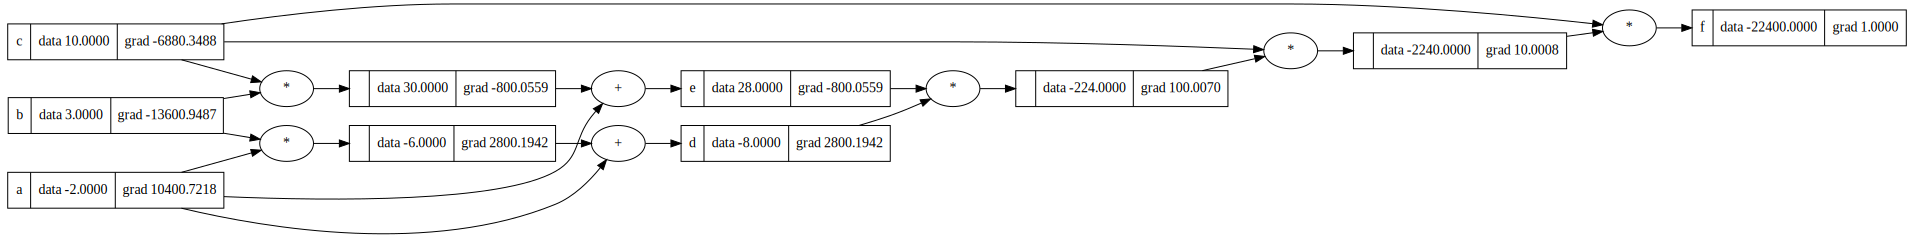

In [137]:
def test3():
  a = Value(-2.0, label='a')
  b = Value(3.0, label='b')
  c = Value(10.0, label='c')
  d = a * b + a; d.label = 'd'
  e = a + b * c; e.label = 'e'
  f = d * e * c * c; f.label = 'f'

  f.backward()
  return f

draw_dot(test3())

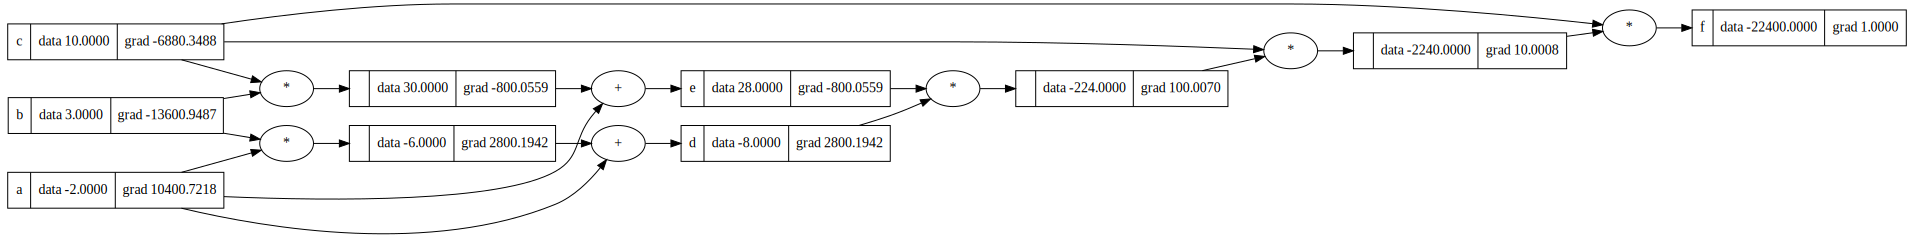

In [138]:
# set autograd to False/True 
draw_dot(test3())

# Playing with Division & Power Operations

In [139]:
def build_graph_tanh():
  # inputs
  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')

  # weights
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')

  # bias
  b = Value(6.8813735870195432, label='b')

  # weights x inputs
  x1w1 = x1 * w1; x1w1.label = 'x1*w1'
  x2w2 = x2 * w2; x2w2.label = 'x2*w2'

  # dot product
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

  # adding the bias
  n = x1w1x2w2 + b; n.label = 'n'

  # implement tanh expression exactly...
  # (e^2x - 1) / (e^2x + 1)
  e = (2 * n).exp(); e.label = 'e'
  o = (e - 1) / (e + 1)
  o.label = 'o'

  return o

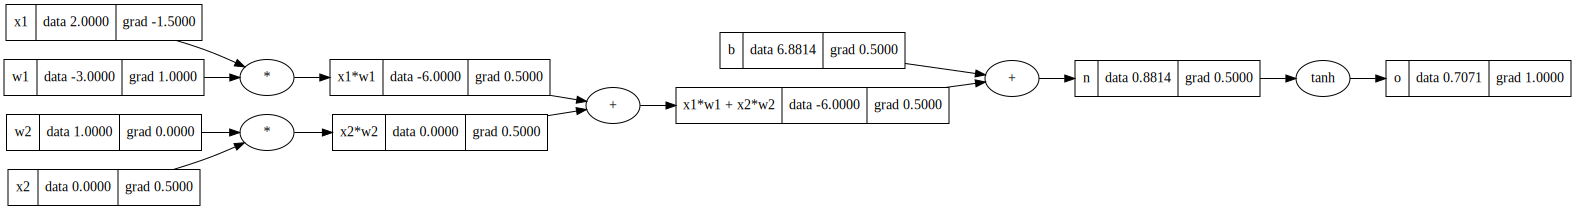

In [140]:
o = build_graph()
o.backward()
draw_dot(o)

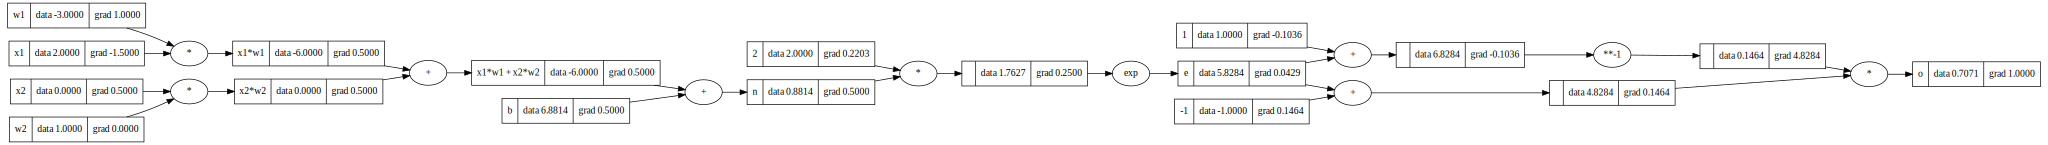

In [141]:
o = build_graph_tanh()
o.backward()
draw_dot(o)

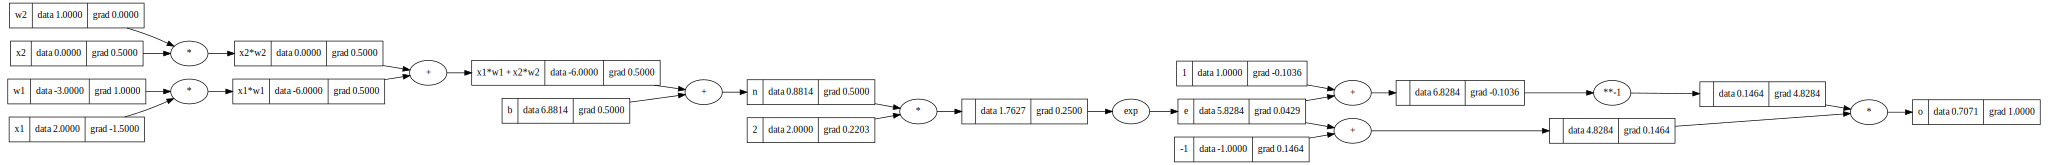

In [142]:
o = build_graph_tanh()
o.backward()
draw_dot(o)

In [143]:
def build_graph_sigmoid():
  # inputs
  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')

  # weights
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')

  # bias
  b = Value(6.8813735870195432, label='b')

  # weights x inputs
  x1w1 = x1 * w1; x1w1.label = 'x1*w1'
  x2w2 = x2 * w2; x2w2.label = 'x2*w2'

  # dot product
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

  # adding the bias
  n = x1w1x2w2 + b; n.label = 'n'

  o = n.sigmoid()
  o.label = 'o'
  return o

def build_graph_softplus():
  # inputs
  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')

  # weights
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')

  # bias
  b = Value(6.8813735870195432, label='b')

  # weights x inputs
  x1w1 = x1 * w1; x1w1.label = 'x1*w1'
  x2w2 = x2 * w2; x2w2.label = 'x2*w2'

  # dot product
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

  # adding the bias
  n = x1w1x2w2 + b; n.label = 'n'

  o = n.softplus()
  o.label = 'o'
  return o

def build_graph_relu():
  # inputs
  x1 = Value(2.0, label='x1')
  x2 = Value(0.0, label='x2')

  # weights
  w1 = Value(-3.0, label='w1')
  w2 = Value(1.0, label='w2')

  # bias
  b = Value(6.8813735870195432, label='b')

  # weights x inputs
  x1w1 = x1 * w1; x1w1.label = 'x1*w1'
  x2w2 = x2 * w2; x2w2.label = 'x2*w2'

  # dot product
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

  # adding the bias
  n = x1w1x2w2 + b; n.label = 'n'

  o = n.relu()
  o.label = 'o'
  return o

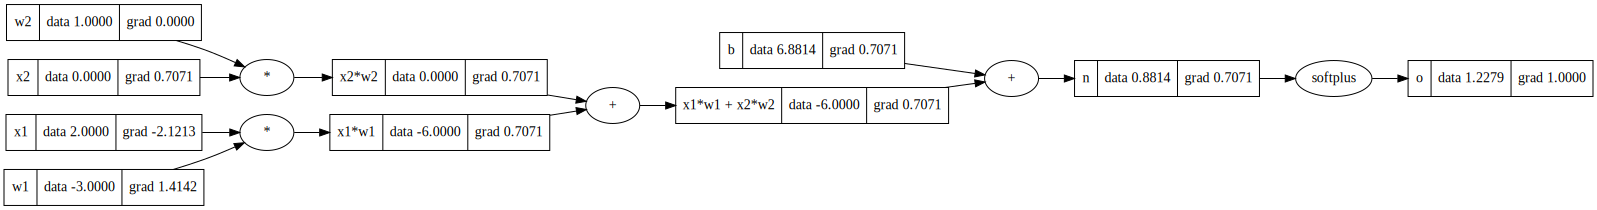

In [144]:
o = build_graph_softplus()
o.backward()
draw_dot(o)

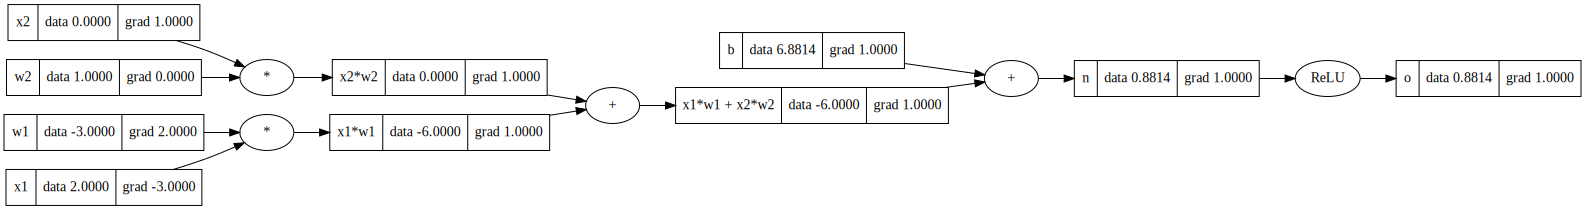

In [145]:
o = build_graph_relu()
o.backward()
draw_dot(o)

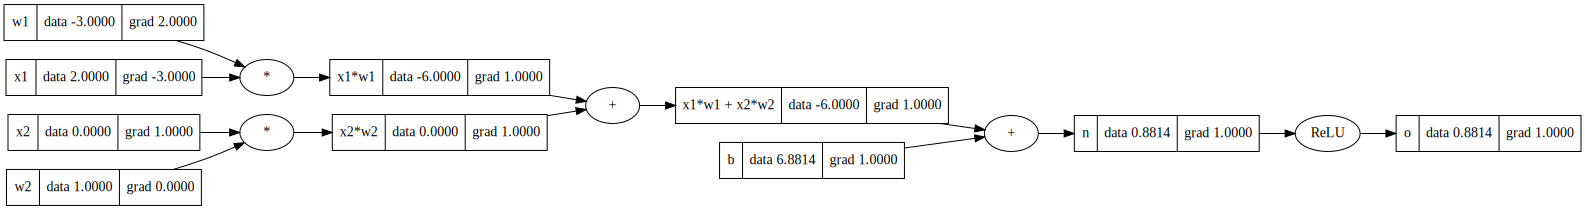

In [146]:
# swap autograd True/False
o = build_graph_relu()
o.backward()
draw_dot(o)

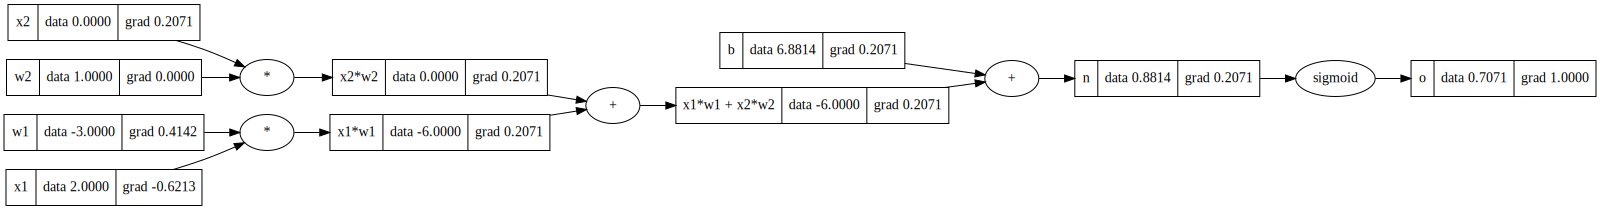

In [147]:
o = build_graph_sigmoid()
o.backward()
draw_dot(o)

# Trying This With Torch

In [148]:
import torch
torch.version

<module 'torch.version' from '/usr/local/lib/python3.8/dist-packages/torch/version.py'>

In [149]:
rg = True
x1 = torch.Tensor([2.0]).double();                x1.requires_grad = rg
x2 = torch.Tensor([0.0]).double();                x2.requires_grad = rg
w1 = torch.Tensor([-3.0]).double();               w1.requires_grad = rg
w2 = torch.Tensor([1.0]).double();                w2.requires_grad = rg
b = torch.Tensor([6.8813735870195432]).double();  b.requires_grad = rg

n = x1 * w1 + x2 * w2 + b
# o = torch.sigmoid(n)
# o = torch.relu(n)
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("------")
print(f"x1: {x1.grad.item()}")
print(f"w1: {w1.grad.item()}")
print(f"x2: {x2.grad.item()}")
print(f"w2: {w2.grad.item()}")

0.7071066904050358
------
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0


In [150]:
torch.Tensor([[1,2,3],[4,5,6]]).dtype

torch.float32

In [151]:
# def test3():
#   a = Value(-2.0, label='a')
#   b = Value(3.0, label='b')
#   c = Value(10.0, label='c')
#   d = a * b + a; d.label = 'd'
#   e = a + b * c; e.label = 'e'
#   f = d * e * c * c; f.label = 'f'

#   f.backward()
#   return f

# draw_dot(test3())
a = torch.Tensor([-2.0]).double(); a.requires_grad = True
b = torch.Tensor([3.0]).double(); b.requires_grad = True
c = torch.Tensor([10.0]).double(); c.requires_grad = True

d = a * b + a
e = a + b * c
f = d * e * c * c

f.backward()
print(f.data.item())

print("----")
print(f"a: {a.grad.item()}")
print(f"b: {b.grad.item()}")
print(f"c: {c.grad.item()}")

-22400.0
----
a: 10400.0
b: -13600.0
c: -6880.0


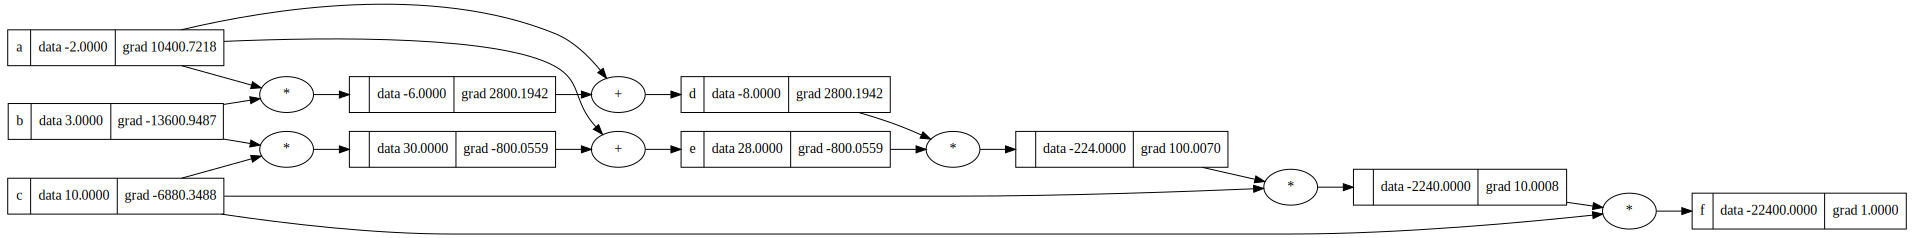

In [152]:
draw_dot(test3())

# Implementing `Neuron` Class

In [153]:
import random
from typing import Any, List

class Neuron:

  def __init__(self, nin: int) -> None:
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1)) # bias
  
  def _activation(self, v: Value) -> Value:
    return v.tanh()

  def __call__(self, x: Any) -> Value:
    # activation(w * x + b)
    act = np.dot(self.w, x) + self.b
    out = self._activation(act)
    return out
  
  def parameters(self) -> List[Value]:
    return self.w + [self.b]

In [154]:
x = [2.0, 3.0]
n = Neuron(len(x))
n(x)

Value(data=0.3819165660454811)

# `Layer` Class

In [155]:
class Layer:

  def __init__(self, nin, nout) -> None:
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]
    
  

In [156]:
x = [2.0, 3.0]
n = Layer(len(x), 3)
n(x)

[Value(data=-0.7674029183400974),
 Value(data=0.9713663174614785),
 Value(data=0.9207463757421062)]

# `MLP` Class

In [157]:
from typing import List

class MLP:

  def __init__(self, nin: int, nouts: List[int]):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for l in self.layers for p in l.parameters()]


# Loss Functions

In [158]:
class LossFunction:

  def __call__(self, outputs: List[Value], targets: List[Value]):
    raise NotImplementedError("Loss function not implemented by sublcass")

class MSE(LossFunction):

  def _mse(self, outputs: List[Value], targets: List[Value]):
    """Implements MSE loss function for a list of outputs & targets"""
    return sum((yout - ygt)**2 for ygt, yout in zip(targets, outputs))

  def __call__(self, outputs: List[Value], targets: List[Value]):
    return self._mse(outputs, targets)

In [159]:
x = [2.0, 3.0, -1.0]
n = MLP(len(x), [4, 4, 1])
loss_func = MSE()
n(x)

Value(data=0.0884815788063107)

In [160]:
n.parameters()

[Value(data=0.31255526637777775),
 Value(data=0.8246106857787521),
 Value(data=-0.7814232047574572),
 Value(data=0.6408752595662697),
 Value(data=-0.20252189189007108),
 Value(data=-0.8693137391598071),
 Value(data=0.39841666323128555),
 Value(data=-0.3037961142013801),
 Value(data=-0.19282493884310759),
 Value(data=0.6032250931493106),
 Value(data=0.6001302646227185),
 Value(data=0.32749776568749045),
 Value(data=0.6650130652363544),
 Value(data=0.1889136153241595),
 Value(data=-0.07813264062433589),
 Value(data=0.9151267732861252),
 Value(data=0.5914405264235476),
 Value(data=-0.3725442040076463),
 Value(data=0.3810827422406471),
 Value(data=0.8301999957053683),
 Value(data=-0.08568482691922008),
 Value(data=-0.4702876239420326),
 Value(data=-0.598037011209763),
 Value(data=-0.8653994554527067),
 Value(data=0.05088685407468296),
 Value(data=0.23734644010332318),
 Value(data=0.15459549089529045),
 Value(data=-0.9122391928398941),
 Value(data=-0.18505999501786086),
 Value(data=0.305845

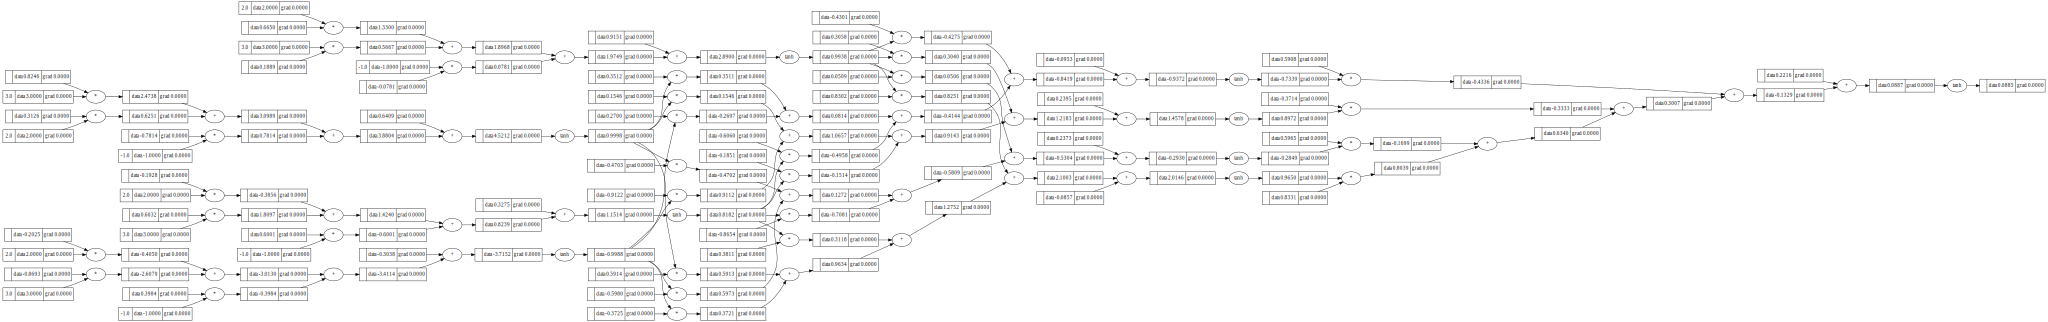

In [161]:
draw_dot(n(x))

# Toy Dataset

In [162]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [163]:
ypred = [n(x) for x in xs]

In [164]:
ypred

[Value(data=0.0884815788063107),
 Value(data=0.6440588710922028),
 Value(data=0.03644613266348931),
 Value(data=0.4985391127317591)]

In [165]:
loss = loss_func(ypred, ys)
loss

Value(data=4.859479011165359)

In [166]:
loss.backward()

## Massive Comp Graph for Entire Dataset Forward Pass

In [167]:
# draw_dot(loss)

In [168]:
n.layers[0].neurons[0].w[0].grad

1.2232737103333595

In [169]:
n.layers[0].neurons[0].w[0].data

0.31255526637777775

# Manually Implementing Gradient Descent

In [170]:
eta = 0.1 
for p in n.parameters():
  # update = val + -eta * grad
  p.data += -eta * p.grad

n.layers[0].neurons[0].w[0].data

0.1902278953444418

# Making a Training Loop

In [171]:
import sys
import copy
from typing import Callable, Any

class MLPTrainer:

  def __init__(self, nn: MLP, loss: LossFunction):
    self.nn = nn
    self.best_checkpoint = nn
    self.loss_func = loss
  
  def model(self) -> MLP:
    return self.best_checkpoint
  
  def zero_grad(self) -> None:
    for p in self.nn.parameters():
      p.grad = 0.0
  
  def update(self, eta):
    for p in self.nn.parameters():
      p.data += -eta * p.grad
  
  def curr_loss(self, 
                ypred: List[Any],
                labels: List[Any]):
    return self.loss_func(ypred, labels)
  
  def train_stats(self,
                  training_data: List[Any],
                  labels: List[Any]):
    # Final stats
    final_pred = [self.best_checkpoint(x) for x in training_data]
    final_loss = self.curr_loss(final_pred, labels)

    # final outputs
    print(f"Training complete! Final loss: {final_loss.data}")

  def train(self, 
            training_data: List[Any],
            labels: List[Any],
            learning_rate: float = 0.01, 
            learning_rate_decay: float = 0.0,
            max_training_steps: int = 100,
            early_stopping_loss: float = 1.0e-5):
    
    # sanity check
    assert len(labels) == len(training_data)
    
    # min loss
    init_pred = [self.best_checkpoint(x) for x in training_data]
    min_loss = self.curr_loss(init_pred, labels).data

    # Training loop
    for k in range(max_training_steps):
      
      # forward pass
      ypred = [self.nn(x) for x in training_data]

      # calculate loss
      loss = self.curr_loss(ypred, labels)
      print(f"Iteration {k+1}: LR: {learning_rate}, Loss: {loss.data}")
      
      # update pointer to best model
      if loss.data < min_loss:
        self.best_checkpoint = copy.deepcopy(self.nn)
        min_loss = loss.data

      if loss.data <= early_stopping_loss:
        print(f"loss <= {early_stopping_loss}... Exiting!")
        break

      # zero out the grad
      self.zero_grad()

      # Backward pass
      loss.backward()

      # Weight update
      self.update(eta=learning_rate)

      # update/decay learning rate
      learning_rate -= learning_rate * learning_rate_decay


# Use Trainer to Train MLP

In [172]:
# Random mapping onto outputs
# xs = [
#     [2.0, 3.0, -1.0],
#     [3.0, -1.0, 0.5],
#     [0.5, 1.0, 1.0],
#     [1.0, 1.0, -1.0],
# ]

# ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Learn the Cosine Function
xs = [[x] for x in np.linspace(-(2 * np.pi), 2 * np.pi, 100).tolist()]
random.shuffle(xs)

ys = [math.cos(x[0]) for x in xs] # targets

# example of the training data
input_dim = 1 if not isinstance(xs[0], List) else len(xs[0])

# initialize MLP
nn = MLP(input_dim, [10, 1])

# initialize MLP trainer
trainer = MLPTrainer(nn=nn, loss=MSE())

# Run training
trainer.train(training_data=xs, 
              labels=ys,
              max_training_steps=100, 
              learning_rate=0.000125, 
              learning_rate_decay=0.0001)

trainer.train_stats(training_data=xs, labels=ys)

Iteration 1: LR: 0.000125, Loss: 94.25807090226085
Iteration 2: LR: 0.0001249875, Loss: 91.85782135169335
Iteration 3: LR: 0.00012497500124999998, Loss: 89.41358215048633
Iteration 4: LR: 0.00012496250374987498, Loss: 86.92946087718823
Iteration 5: LR: 0.0001249500074995, Loss: 84.40955116811931
Iteration 6: LR: 0.00012493751249875005, Loss: 81.85902953997285
Iteration 7: LR: 0.00012492501874750018, Loss: 79.28563681823827
Iteration 8: LR: 0.00012491252624562542, Loss: 76.70131497413477
Iteration 9: LR: 0.00012490003499300085, Loss: 74.12363848728046
Iteration 10: LR: 0.00012488754498950154, Loss: 71.57656007136839
Iteration 11: LR: 0.0001248750562350026, Loss: 69.08998043194882
Iteration 12: LR: 0.0001248625687293791, Loss: 66.69781559780088
Iteration 13: LR: 0.00012485008247250617, Loss: 64.43462754074571
Iteration 14: LR: 0.00012483759746425893, Loss: 62.33142081783327
Iteration 15: LR: 0.0001248251137045125, Loss: 60.41164346176761
Iteration 16: LR: 0.00012481263119314205, Loss: 58

In [173]:
# Print final outputs
print("Summary outputs:\n-----------------")
model = trainer.model()
model_pred = [model(x) for x in xs]
model_loss = trainer.curr_loss(model_pred, ys)
print(f"Final Training Loss: {model_loss.data}")
for o, t in zip(model_pred, ys):
  print("---------------------\n"\
        f"Truth: {t:.3f}\n"\
        f"Model: {o.data:.3f}")

Summary outputs:
-----------------
Final Training Loss: 40.1471847837783
---------------------
Truth: 0.982
Model: 0.207
---------------------
Truth: -0.824
Model: -0.007
---------------------
Truth: -0.701
Model: 0.047
---------------------
Truth: -0.016
Model: 0.093
---------------------
Truth: 0.998
Model: 0.215
---------------------
Truth: 0.472
Model: 0.133
---------------------
Truth: 0.174
Model: -0.026
---------------------
Truth: -0.205
Model: 0.017
---------------------
Truth: -0.205
Model: -0.022
---------------------
Truth: 0.766
Model: 0.167
---------------------
Truth: -0.987
Model: 0.018
---------------------
Truth: -0.655
Model: -0.058
---------------------
Truth: 0.982
Model: 0.213
---------------------
Truth: 0.903
Model: 0.189
---------------------
Truth: 0.679
Model: 0.155
---------------------
Truth: 1.000
Model: -0.031
---------------------
Truth: 0.992
Model: -0.031
---------------------
Truth: 0.992
Model: 0.199
---------------------
Truth: -0.327
Model: -0.020


In [174]:
len(x[:1])

1

In [175]:
model_pred = model(xs[0])
model_loss = trainer.curr_loss([model_pred], [ys[0]])
model_loss.backward()
# draw_dot(model_loss)

# Trying a Different Problem & Loss Function

Initialize a model

In [176]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


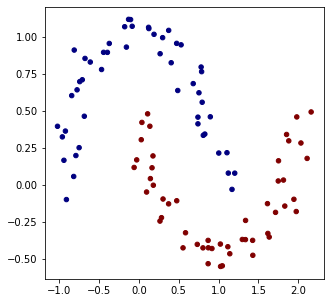

In [177]:
np.random.seed(1337)
random.seed(1337)

# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [178]:
y

array([-1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1, -1,  1,
        1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,
        1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1,
        1, -1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,
        1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1])

In [179]:
type(X[:3])

numpy.ndarray

In [180]:
def loss(batch_size=None):

  # Data loader
  if batch_size is None:
    Xb, yb = X, y
  else:
    ri = np.random.permutation(X.shape[0])[:batch_size]
    Xb, yb = X[ri], y[ri]

  inputs = [list(map(Value, xrow)) for xrow in Xb]

  # forward pass
  scores = list(map(model, inputs))

  # SVM max-margin loss
  losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
  data_loss = sum(losses) * (1.0 / len(losses))

  # L2 regularization
  # alpha * ||w||_2^2
  alpha = 1e-4
  reg_loss = alpha * sum((p * p for p in model.parameters()))
  total_loss = data_loss + reg_loss

  # also get accuracy
  accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
  return total_loss, sum(accuracy) / len(accuracy)


In [181]:
total_loss, acc = loss()
print(f"total_loss: {total_loss}, accuracy: {acc}")

total_loss: Value(data=0.7691342604056346), accuracy: 0.67


In [188]:
# optimization
for k in range(100):

  # forward
  total_loss, acc = loss()
  print(f"ITER {k} -- total_loss: {total_loss.data:.6f}, accuracy: {acc}")

  # backward
  # model.zero_grad()
  for p in model.parameters():
    p.grad = 0.0
  
  total_loss.backward()

  # update (with learning rate decay)
  learning_rate = 1.0 - 0.9*k/100
  for p in model.parameters():
    p.data += -learning_rate * p.grad
  
  # break early if acc is 100%
  if acc >= 1.0:
    print(f"Acc reached: {acc}, breaking early!")
    break


ITER 0 -- total_loss: 0.179562, accuracy: 0.94
ITER 1 -- total_loss: 0.194283, accuracy: 0.93
ITER 2 -- total_loss: 0.182498, accuracy: 0.93
ITER 3 -- total_loss: 0.204180, accuracy: 0.91
ITER 4 -- total_loss: 0.160076, accuracy: 0.94
ITER 5 -- total_loss: 0.143377, accuracy: 0.95
ITER 6 -- total_loss: 0.136516, accuracy: 0.96
ITER 7 -- total_loss: 0.161079, accuracy: 0.94
ITER 8 -- total_loss: 0.145664, accuracy: 0.96
ITER 9 -- total_loss: 0.163147, accuracy: 0.93
ITER 10 -- total_loss: 0.124322, accuracy: 0.95
ITER 11 -- total_loss: 0.107046, accuracy: 0.97
ITER 12 -- total_loss: 0.115175, accuracy: 0.98
ITER 13 -- total_loss: 0.171338, accuracy: 0.93
ITER 14 -- total_loss: 0.112924, accuracy: 0.95
ITER 15 -- total_loss: 0.081759, accuracy: 0.98
ITER 16 -- total_loss: 0.077760, accuracy: 0.99
ITER 17 -- total_loss: 0.074158, accuracy: 0.99
ITER 18 -- total_loss: 0.070889, accuracy: 0.99
ITER 19 -- total_loss: 0.068133, accuracy: 0.99
ITER 20 -- total_loss: 0.068007, accuracy: 1.0
Acc

(-1.548639298268643, 1.951360701731357)

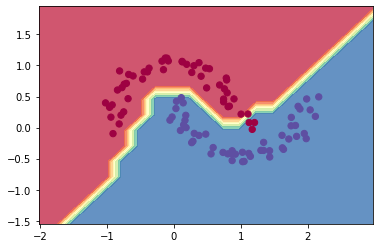

In [189]:
 # visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [190]:
def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.tanh() + z * x
    h = (z * z).tanh()
    # q = z.relu() + z * x
    # h = (z * z).relu()
    # q = z.softplus() + z * x
    # h = (z * z).softplus()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    # q = z.relu() + z * x
    # h = (z * z).relu()
    q = z.tanh() + z * x
    h = (z * z).tanh()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    tolerance = 1e-3
    # forward pass went well
    print(f"ymg.data: {ymg.data}, ypt.data: {ypt.data.item()}")
    assert abs(ymg.data - ypt.data.item()) <= tolerance
    # backward pass went well
    print(f"xmg.grad: {xmg.grad}, xpt.grad: {xpt.grad.item()}")
    assert abs(xmg.grad - xpt.grad.item()) <= tolerance

test_sanity_check()

ymg.data: -116.00000001236691, ypt.data: -116.00000001236691
xmg.grad: 104.99971597396348, xpt.grad: 104.99999992992078


In [191]:
def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    # d += d * 2 + (b + a).relu()
    # d += 3 * d + (b - a).relu()
    d += d * 2 + (b + a).tanh()
    d += 3 * d + (b - a).tanh()
    e = c - d
    f = e**2
    g = f / 2.0
    g += Value(10.0) / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    # d = d + d * 2 + (b + a).relu()
    # d = d + 3 * d + (b - a).relu()
    d = d + d * 2 + (b + a).tanh()
    d = d + 3 * d + (b - a).tanh()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-4
    # forward pass went well
    print(f"gmg.data: {gmg.data}, gpt.data: {gpt.data.item()}")
    assert abs(gmg.data - gpt.data.item()) < tol
    
    # backward pass went well
    print(f"amg.grad: {amg.grad}, apt.grad: {apt.grad.item()}")
    # assert abs(amg.grad - apt.grad.item()) < tol

    print(f"bmg.grad: {bmg.grad}, bpt.grad: {bpt.grad.item()}")
    assert abs(bmg.grad - bpt.grad.item()) < tol

test_more_ops()

gmg.data: 4.625192144640556, gpt.data: 4.625192144640555
amg.grad: 27.060132170806668, apt.grad: 27.060135135849503
bmg.grad: 117.33447062123975, bpt.grad: 117.33448345392043
